# Import

In [1]:
import os,sys
import datetime

#import time
import pandas as pd
import numpy as np

import scrublet as scr
import scipy.io

import anndata as ad

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import scanpy as sc
sc.logging.print_header()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.10.1 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12
Memory usage: current 0.27 GB, difference +0.27 GB


In [3]:
# add the utility functions folder to PATH
sys.path.append(os.path.abspath("../packages"))
from db_dev.helper import *

plt.rcParams['figure.dpi']= 150

### Load data

In [4]:
home_dir = os.path.expanduser("~")
adata = sc.read_h5ad(home_dir+"/NAS/data/241026_VH00821_549_AAG3VKYM5_trimmed_tso_PE/adatas/mito_total_counts_filt_raw_26287x37733_241031_14h20.h5ad")

# Doublet detection with Scrublet

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.25
Detected doublet rate = 5.8%
Estimated detectable doublet fraction = 41.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 13.9%
Elapsed time: 3.6 seconds


/var/folders/sv/fwsrf8xs57jd9rtwwfxmyxg80000gn/T/ipykernel_6150/3842780527.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_library.obs["doublet_score"] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 3.6%
Estimated detectable doublet fraction = 44.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.0%
Elapsed time: 4.9 seconds


/var/folders/sv/fwsrf8xs57jd9rtwwfxmyxg80000gn/T/ipykernel_6150/3842780527.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_library.obs["doublet_score"] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 1.7%
Estimated detectable doublet fraction = 16.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.1%
Elapsed time: 15.7 seconds


/var/folders/sv/fwsrf8xs57jd9rtwwfxmyxg80000gn/T/ipykernel_6150/3842780527.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_library.obs["doublet_score"] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.2%
Elapsed time: 3.0 seconds


/var/folders/sv/fwsrf8xs57jd9rtwwfxmyxg80000gn/T/ipykernel_6150/3842780527.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_library.obs["doublet_score"] = doublet_scores


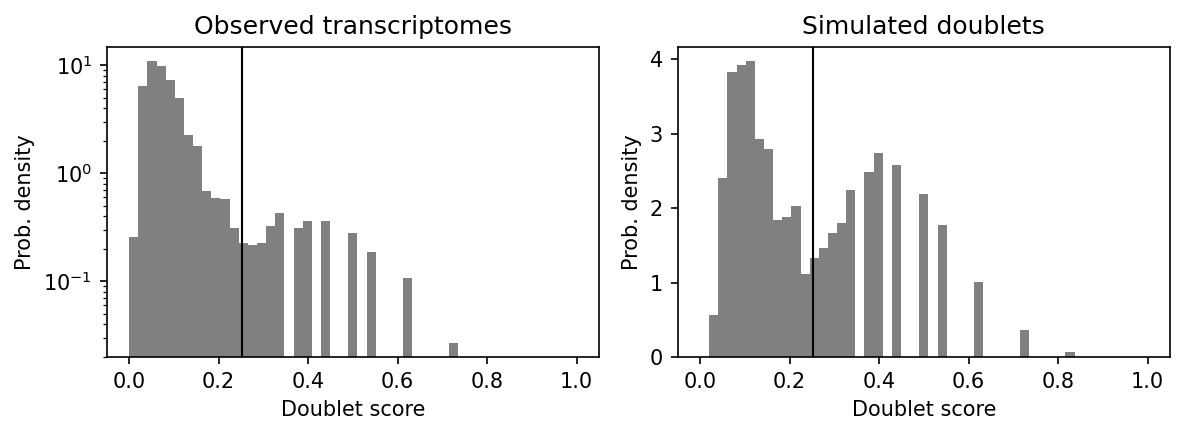

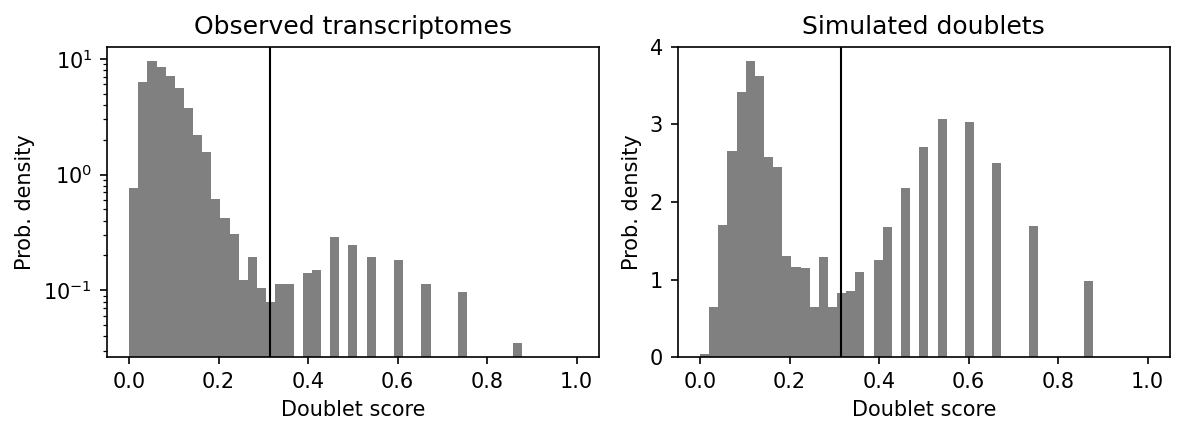

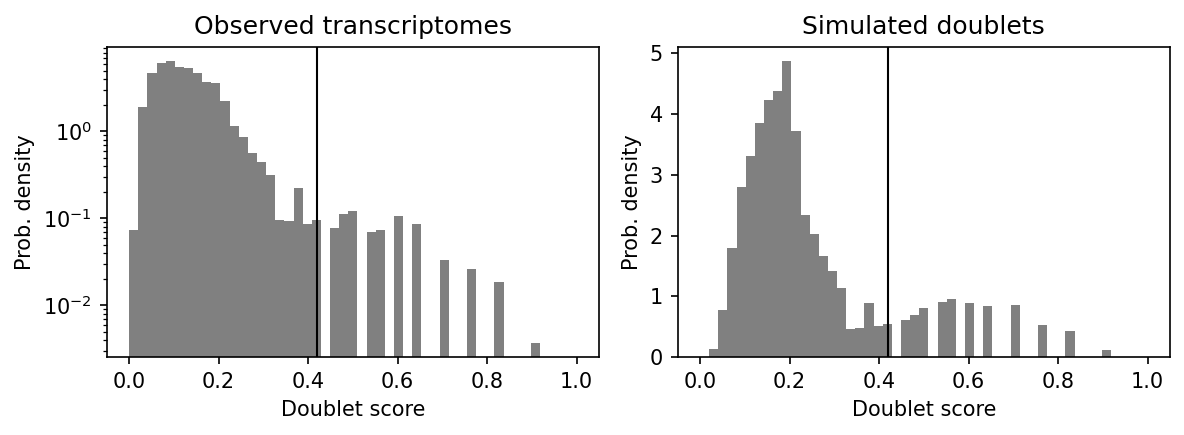

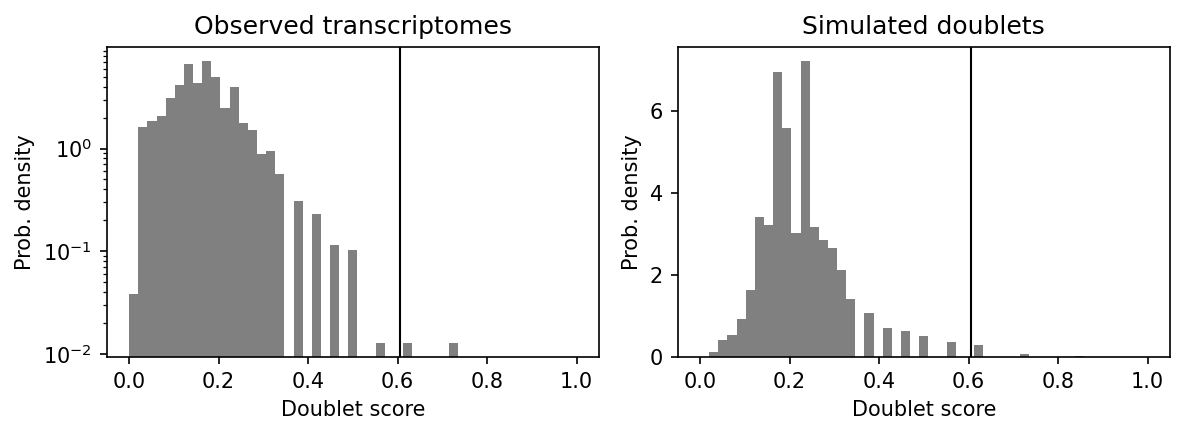

In [7]:

adata_libraries = []
scurb_list = []

observed_doublet_rate = [0.1, 0.1, 0.1, 0.1] # set observed doublet rate for each encapsulation run

for i, library in enumerate(list(adata.obs["sample_code"].unique())):
    adata_library = adata.copy()
    adata_library = adata_library[adata_library.obs["sample_code"] == library]
    
    scrub = scr.Scrublet(adata_library.X, expected_doublet_rate = observed_doublet_rate[i])
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=3,
                                                          min_cells=3,
                                                          min_gene_variability_pctl=85,
                                                          n_prin_comps=30)

    scrub.plot_histogram()
    
    adata_library.obs["doublet_score"] = doublet_scores
    adata_libraries.append(adata_library)

    scurb_list.append(scrub)


['UL, 2-FM02-NP0000041']
Detected doublet rate = 7.4%
Estimated detectable doublet fraction = 48.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 15.3%
['UL, 5-FM02-NP0000029']
Detected doublet rate = 4.4%
Estimated detectable doublet fraction = 49.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.9%
['UL, 2-FM02-NP0000045']
Detected doublet rate = 3.0%
Estimated detectable doublet fraction = 22.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 13.4%
['UL, 2-FM02-NP0000014']
Detected doublet rate = 2.8%
Estimated detectable doublet fraction = 10.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 26.6%
% of doublets in adata:  3.9068741202875947 %
doublets in adata:  1027


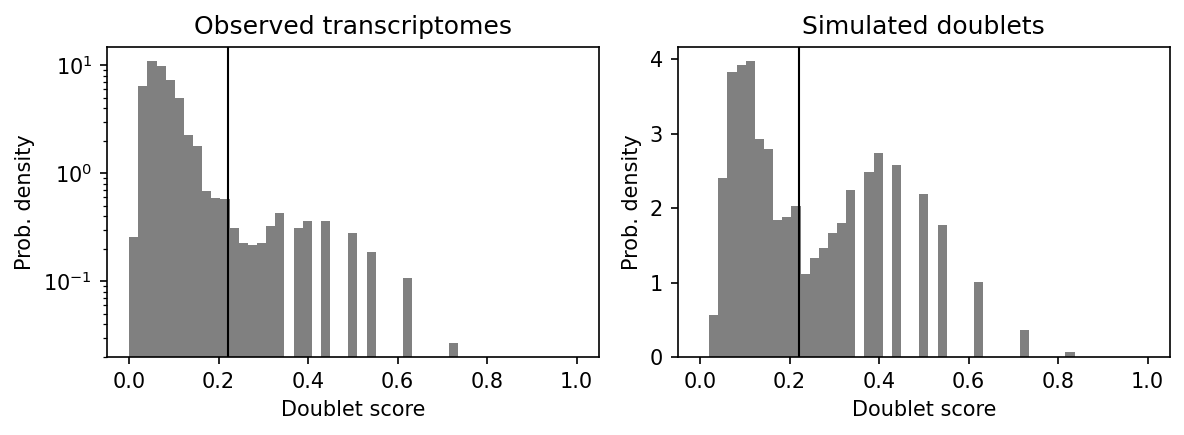

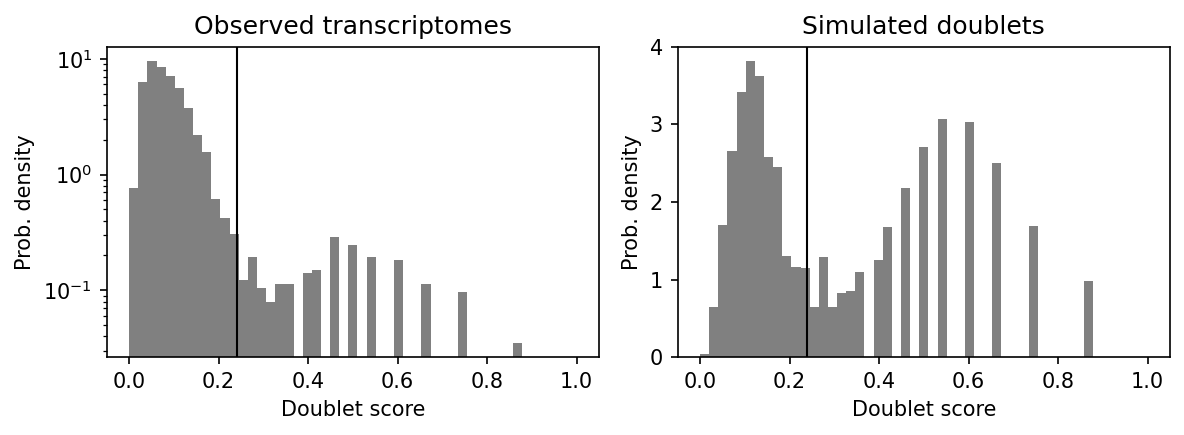

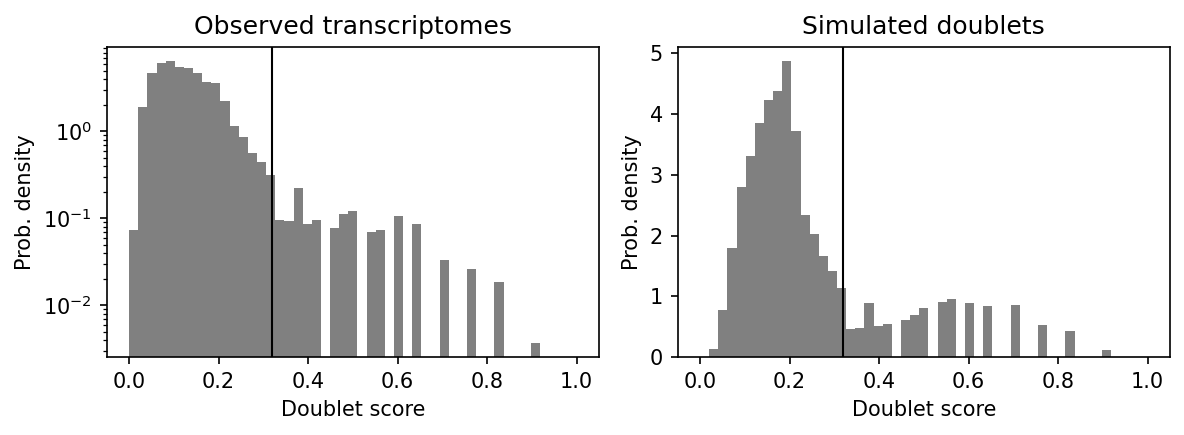

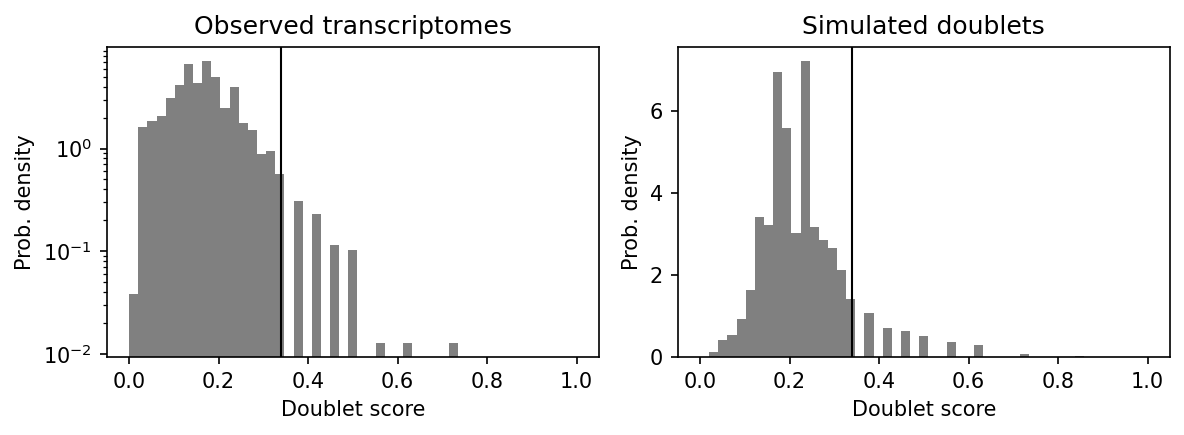

In [8]:
# Setting threshold for each encapsulation run
doublet_scores_threshold = [0.22, 0.24, 0.32, 0.34]

for i, adata_library in enumerate(adata_libraries):
    doublet_subset = adata_library.obs["doublet_score"] > doublet_scores_threshold[i]
    adata_library.obs["predicted_doublet"] = doublet_subset

    print(list(adata_library.obs["sample_code"].unique()))
    scurb_list[i].call_doublets(threshold = doublet_scores_threshold[i])
    scurb_list[i].plot_histogram()


#adata_doublet = ad.concat(adata_libraries)

adata_doublet = ad.concat(adata_libraries, uns_merge = "first")

print("% of doublets in adata: ", str((sum(adata_doublet.obs.predicted_doublet)/len(adata_doublet))*100), "%")
print("doublets in adata: ", sum(adata_doublet.obs.predicted_doublet))

In [9]:
adata_doublet.obs.predicted_doublet.sum()

for i in adata.obs.sample_code.unique():
    print(i, adata_doublet[adata_doublet.obs["sample_code"] == i].obs.predicted_doublet.sum())

UL, 2-FM02-NP0000041 272
UL, 5-FM02-NP0000029 248
UL, 2-FM02-NP0000045 401
UL, 2-FM02-NP0000014 106


# Save the adata object

In [14]:
# directory
#!mkdir -p backups

# write the entire adata_doublet.object
start = time.time()
fname1 = home_dir+"/NAS/data/241026_VH00821_549_AAG3VKYM5_trimmed_tso_PE/adatas/mito_total_counts_filt_doublet_%dx%d_%s.h5ad"%(adata_doublet.shape[0],adata_doublet.shape[1],now())
print(fname1)
adata_doublet.write(fname1)
print(time.time()-start)



# write the pandas dataframe under adata_doublet.obs as a separate file
meta = adata_doublet.obs
fname2 = home_dir+"/NAS/data/241026_VH00821_549_AAG3VKYM5_trimmed_tso_PE/adatas/obs_info_doublet_%dx%d_%s"%(meta.shape[0],meta.shape[1],now())
print(fname2)
save_df(meta,fname2)
print(time.time()-start)

/Users/denis/NAS/data/241026_VH00821_549_AAG3VKYM5_trimmed_tso_PE/adatas/mito_total_counts_filt_doublet_26287x37733_241031_14h36.h5ad
110.69983625411987
/Users/denis/NAS/data/241026_VH00821_549_AAG3VKYM5_trimmed_tso_PE/adatas/obs_info_doublet_26287x15_241031_14h37
111.15255331993103


In [15]:
sum(adata_doublet.obs.predicted_doublet)

1027

In [16]:
sum(adata_doublet.obs.predicted_doublet)/len(adata_doublet)*100

3.9068741202875947